<a href="https://colab.research.google.com/github/KT2001/Omdena_Algeria_Project_OneShotLearning/blob/main/One_Shot_classification_PlantVillage_Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Siamese Neural Network for Tomato yellow curl leaf virus against Healthy Tomatos.`

### Importing the dependecies

In [1]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# visulizations
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import random
import time
import cv2
import glob
from scipy import misc
import pathlib

In [2]:
tf.__version__

'2.9.2'

In [3]:
!nvidia-smi

Wed Oct 26 08:01:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Collecting the data

In [ ]:
!unzip /content/drive/MyDrive/PlantVillage/One_shot_dataset.zip

In [6]:
num_classes = {}
sum = 0
dir = os.listdir('/content/One_shot_dataset')
print(f"Number of classes: {len(dir)} \n")
for filenames in dir:
  num_classes[filenames] = len(os.listdir(f"{'/content/One_shot_dataset'}/{filenames}"))
  sum = num_classes[filenames]+sum
  print(f"{filenames}: {(num_classes[filenames])}")
print(f"\nTotal number of images: {sum}")

Number of classes: 3 

NEG_IMAGES (Tomato_healthy): 1000
POS_IMAGES (Tomato_yellow_curl_virus): 1000
ANC_IMAGES: 1000

Total number of images: 3000


In [7]:
plants=list(num_classes.keys())
values=list(num_classes.values())

<Figure size 2160x720 with 0 Axes>

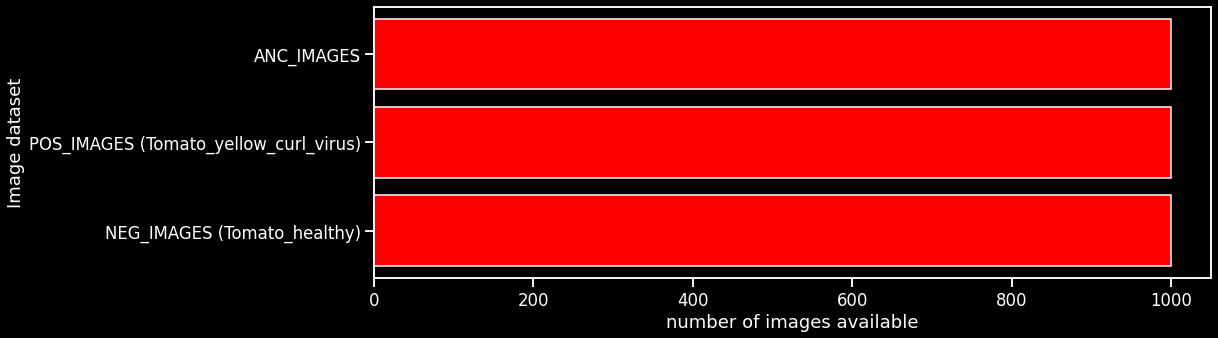

<Figure size 2160x720 with 0 Axes>

In [8]:
plt.figure(figsize=(15, 5))
plt.xlabel("number of images available")
plt.ylabel("Image dataset")
plt.barh(plants, values, color = 'Red', capsize = 10)
plt.figure(figsize=(30, 10))

In [9]:
Pos_path = os.path.join('/content/One_shot_dataset/POS_IMAGES(Tomato_yellow_curl_virus)')
Neg_path = os.path.join('/content/One_shot_dataset/NEG_IMAGES(Tomato_healthy)')
Anc_path = os.path.join('/content/One_shot_dataset/ANC_IMAGES')

**We would have to rename our images so that they can easily be processed.**

(One small part here is that we would have to manually change the name of
`NEG_IMAGES (Tomato_healthy)-->NEG_IMAGES(Tomato_healthy)` and 
`POS_IMAGES (Tomato_yellow_curl_virus)-->POS_IMAGES(Tomato_yellow_curl_virus)`, so if renamer function is not working please do that)

In [12]:
def renamer(path):
  i = 0
  for filename in os.listdir(path):
      my_dest ="image" + str(i) + ".jpg"
      my_source =path +'/'+ filename
      my_dest =path +'/'+ my_dest
      # rename() function will
      # rename all the files
      os.rename(my_source, my_dest)
      i += 1

In [13]:
renamer(Anc_path)
renamer(Pos_path)
renamer(Neg_path)

In [14]:
anchor = tf.data.Dataset.list_files(Anc_path+'/*.jpg').take(1000)
positive = tf.data.Dataset.list_files(Pos_path+'/*.jpg').take(1000)
negative = tf.data.Dataset.list_files(Neg_path+'/*.jpg').take(1000)

the size of the image in the original paper was 105x105x1 but considering we have 3 colour channels here we will have 105x105x3.

In [15]:
def preprocess(path):
  # read an image from file path
  byte_img = tf.io.read_file(path)
  # Load the image
  img = tf.io.decode_jpeg(byte_img)

  # preprocess steps - resize image to be 105x105x3
  img = tf.image.resize(img, (105, 105))
  # scaling the image between 0, 1
  img = img/255.0

  return img

### Creating labelled dataset

In [65]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [18]:
samples = data.as_numpy_iterator()

In [19]:
example = samples.next()

In [20]:
res = preprocess_twin(*example)

b'/content/One_shot_dataset/POS_IMAGES(Tomato_yellow_curl_virus)/image734.jpg'


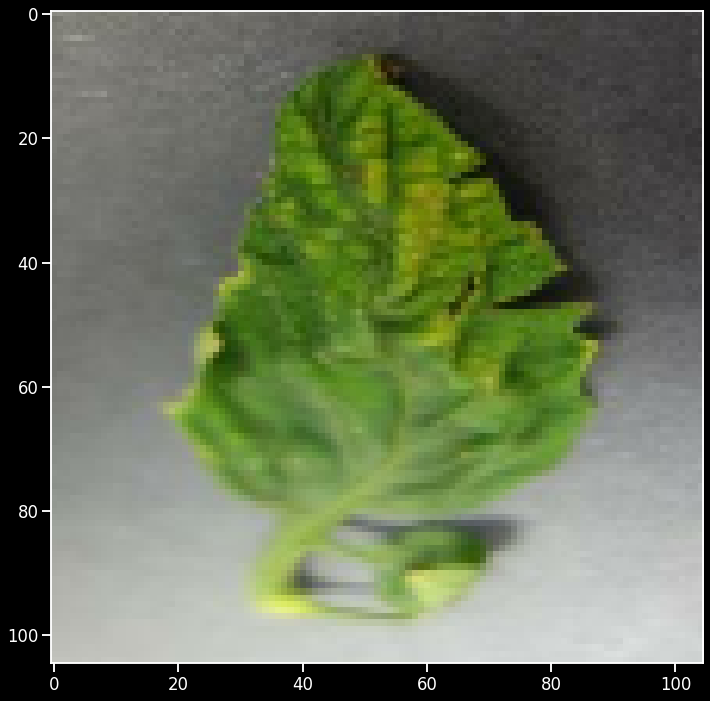

In [21]:
print(example[1])
plt.imshow(res[1])

b'/content/One_shot_dataset/ANC_IMAGES/image152.jpg'


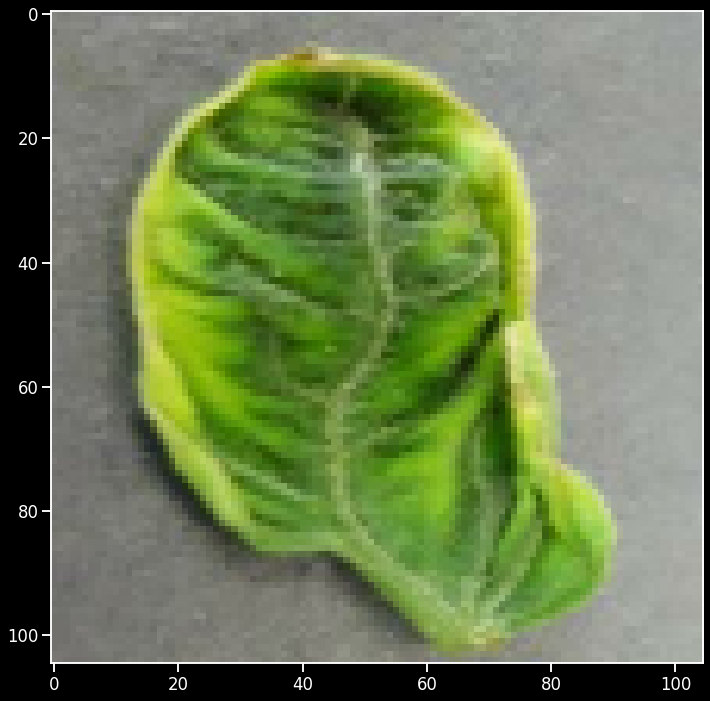

In [22]:
print(example[0])
plt.imshow(res[0])

In [66]:
# building a dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024, seed = 42)

In [67]:
samples = data.as_numpy_iterator()

In [68]:
len(samples.next())

3

In [69]:
example = samples.next()

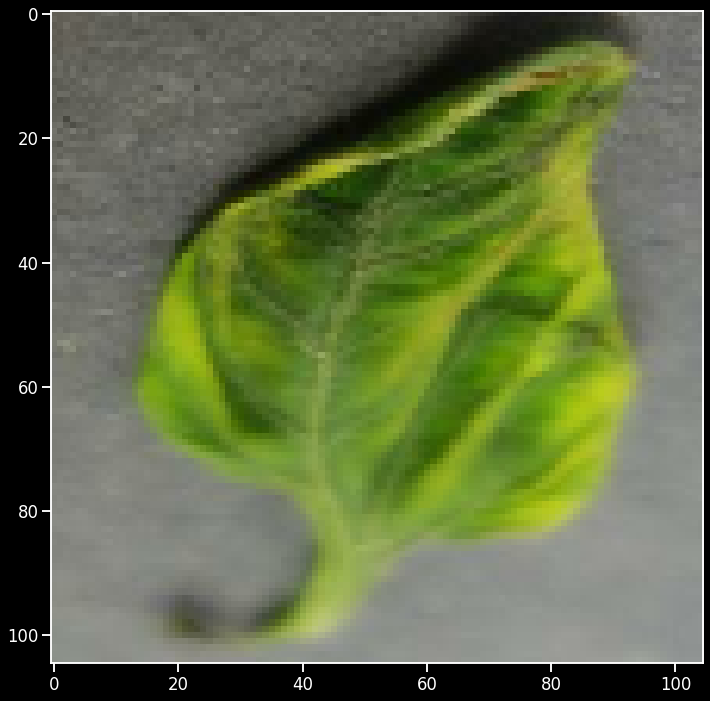

In [70]:
plt.imshow(example[1])

In [72]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [73]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### Building the model

In [31]:
# building an embedding layer
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [32]:
embedding = make_embedding()

In [33]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [34]:
# Siamese L1 Distance class
class L1Dist(Layer):

    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [35]:
l1 = L1Dist()
l1

In [36]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese_Network')

In [74]:
siamese_model = make_siamese_model()

In [75]:
siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0]

### Building checkpoints

In [39]:
loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [40]:
os.mkdir('training_checkpoints')

In [41]:
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### Training the model

In [76]:
# train function
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        Loss = loss(y, yhat)
        
    # Calculate gradients
    grad = tape.gradient(Loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return Loss

In [43]:
len(train_data)

44

In [44]:
test_batch = train_data.as_numpy_iterator()

In [45]:
len(test_data)

19

In [46]:
batch1 = test_batch.next()

In [47]:
X = batch1[:2]

In [48]:
labels = batch1[2]
labels

array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

In [49]:
len(batch1[2])

16

In [50]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [77]:
# building the training loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(f"Loss: {loss.numpy()}, Recall: {r.result().numpy()},Precision: {p.result().numpy()}")
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [78]:
train(train_data, 10)


 Epoch 1/10
44/44 [==============================] - 15s 333ms/step
Loss: 0.3035988509654999, Recall: 0.7832369804382324,Precision: 0.9926739931106567

 Epoch 2/10
44/44 [==============================] - 15s 331ms/step
Loss: 0.18091028928756714, Recall: 0.9467787146568298,Precision: 0.9854227304458618

 Epoch 3/10
44/44 [==============================] - 14s 324ms/step
Loss: 0.12753182649612427, Recall: 0.9617646932601929,Precision: 0.9939209818840027

 Epoch 4/10
44/44 [==============================] - 14s 317ms/step
Loss: 0.04698127135634422, Recall: 0.9745042324066162,Precision: 1.0

 Epoch 5/10
44/44 [==============================] - 14s 314ms/step
Loss: 0.11376439034938812, Recall: 0.9828571677207947,Precision: 0.9856733679771423

 Epoch 6/10
44/44 [==============================] - 15s 330ms/step
Loss: 0.04174898564815521, Recall: 0.991253674030304,Precision: 1.0

 Epoch 7/10
44/44 [==============================] - 15s 330ms/step
Loss: 0.019893793389201164, Recall: 0.9942693

In [79]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

### Validating the result

In [80]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 22ms/step


In [81]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]

In [82]:
y_true

array([1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [83]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [84]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [85]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 24ms/step
1.0 1.0


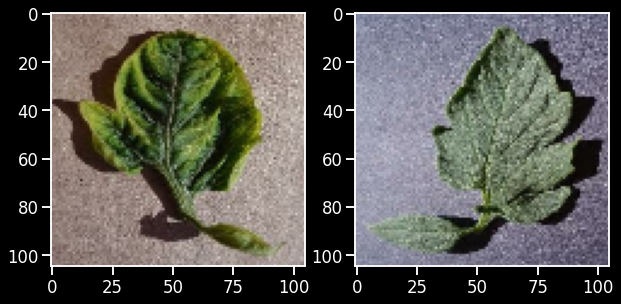

In [88]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [87]:
# saving the model
siamese_model.save('siamesemodelV2.h5')